# What a CNN sees - Visualize the `model_scratch`

In this notebook i will show you how you can visualize the layers of a CNN. This helps us to a better understanding what a CNN sees and how it learns.  
For this demonstration I use the model from scratch constructed in dog_app.ipynb.  
The demonstration is based on the following source: [Visualizing Convolution Neural Networks using Pytorch](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)  
and the related Github-repo that you can find here: [Github - VisualizationCNN_Pytorch](https://github.com/Niranjankumar-c/DeepLearning-PadhAI/tree/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch)

In [69]:
# import the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# To visualize the data set we will implement the custom function imshow.
def imshow(img, title):
    """Custom function to display the image using matplotlib"""
    #define std correction to be made
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    #define mean correction to be made
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)

    #convert the tensor img to numpy img and de normalize 
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction

    #plot the numpy image
    plt.figure(figsize = (batch_size * 4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [87]:
import torch.nn as nn
import torch.nn.functional as F

# This is the same CNN architecture as in the dog_app.ipynb
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define CNN layers
        
        self.conv1 = nn.Conv2d( 3, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d( 64, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define fully connected layers
        self.fc1 = nn.Linear(14*14*128, 4096)
        self.fc2 = nn.Linear(4096, 133)
        
        # drop-out
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        #print(x.shape)
        # flatten
        x = x.view(-1, 14*14*128)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x
    
# instantiate the CNN
model_scratch = Net()

In [96]:
# import saved weights to the model
device = torch.device('cpu')
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=device))
model_scratch.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [97]:
type(model_scratch.conv1)

torch.nn.modules.conv.Conv2d

In [91]:
# This helper-functions are imported from the related Github-repo
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    #fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))
    fig, ax = plt.subplots(figsize=(20, 15))  
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

    
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    #plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [63]:
# Main function to plot the weights of the model
def plot_weights(model_layer, single_channel = True, collated = False):
    '''
    Plot the weights of a pretrained/saved model
    
    Args:
        model_layer:    pretrained or saved model and layer
        single_channel: Visualization mode
        collated:       Applicable for single-channel visualization only
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    #extracting the model features at the particular layer number
    layer = model_layer
    
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = layer.weight.data.clone()
        weight_tensor = weight_tensor.cpu()
        
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")

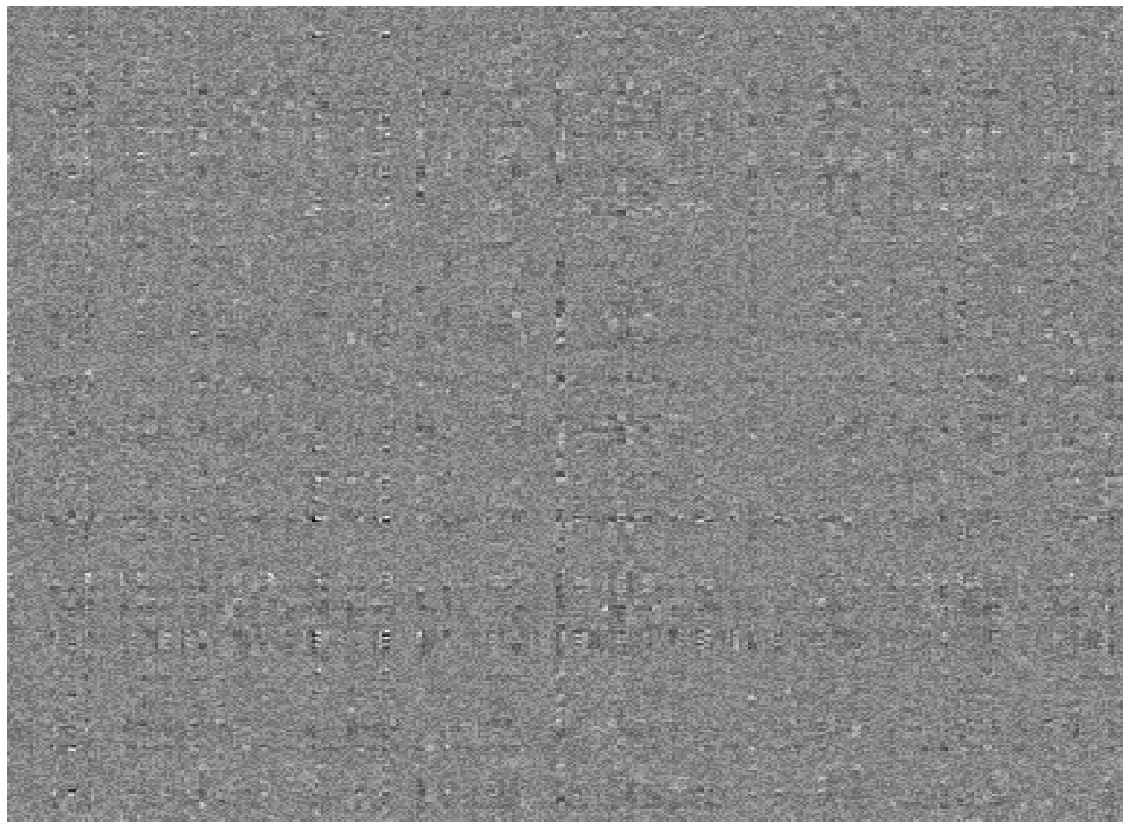

In [98]:
#visualize weights for model_scratch - first conv layer
plot_weights(model_scratch.conv4, single_channel = True, collated=True)

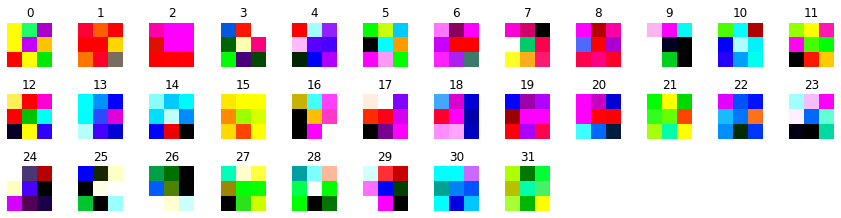

In [99]:
plot_weights(model_scratch.conv1, single_channel=False, collated=False)